# An example usage of CRAFT

We demostrate how we can use CRAFT to produce the result shown in the last row of Figure 8 in [Cooray et al. (2020)](https://doi.org/10.1093/mnras/staa3580).

We will input a simple theoretical model described in the above paper and generate artificial observations of Stokes *Q* and *U* by supposing a frequency coverage of 350 MHz to 1760 MHz (future SKA1 mid bands 1 and 2). There after, we use CRAFT to reconstruct the spectrum. 

First, import the necessary packages including CRAFT. Easiest way is to just copy the CRAFT script to your notebook location.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

import craft

Let us read the model file, reformat it, and plot.

In [2]:
plt.rcParams.update({'figure.dpi': 200})

model_data = pd.read_csv("simple_model_FDF.csv")

FDF_model = pd.DataFrame({'Faraday depth':model_data['Faraday depth'],
                         'Real FDF':model_data['Real FDF'],
                         'Imag FDF':model_data['Imag FDF'],
                         'Complex FDF':model_data['Real FDF']+1j*model_data['Imag FDF'],
                         'Abs FDF':np.abs(model_data['Real FDF']+1j*model_data['Imag FDF'])})

Text(0, 0.5, '|$F(\\phi)$|  [mJy rad$^{-1}$ m$^2$]')

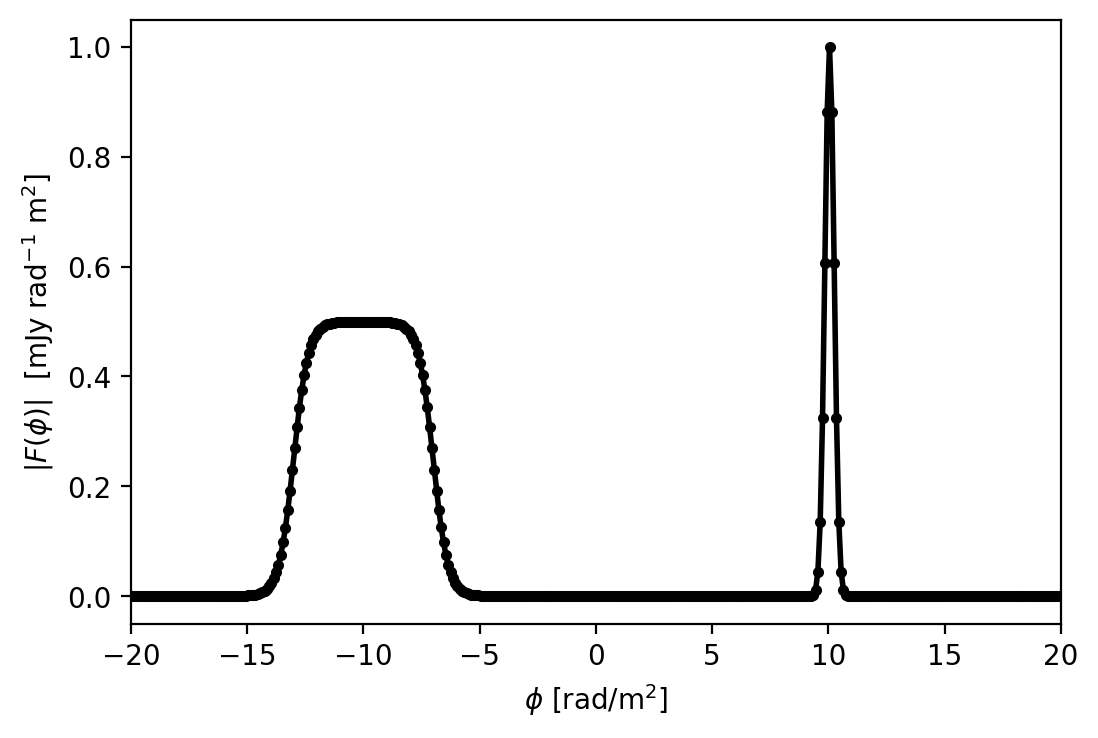

In [3]:
plt.plot(FDF_model['Faraday depth'], FDF_model['Abs FDF'], '.-k', lw=2)

plt.xlim(-20, 20)
plt.xlabel(r"$\phi$ [rad/m$^{2}$]")
plt.ylabel(r"|$F(\phi)$|  [mJy rad$^{-1}$ m$^2$]")

Now we generate artificial observations. Set the frequency range and the noise parameter.

In [4]:
f_min, f_max = 350, 1760 # in MHz
noise_scale = 0.1

ls_min, ls_max = craft.MHz2m2(f_max), craft.MHz2m2(f_min)
FWHM = craft.rmsf_fwhm(ls_min, ls_max)

print("Frequency limits (MHz) =", f_min, f_max)
print("lambda^2 limits (m^2) =", ls_min, ls_max)
print(f"FWHM = {FWHM}")
print(f"Polarization angle smoothing scale = {craft.chi_smoothing_scale(ls_min, ls_max)}")
print(f"Minimum recon scale = {craft.min_reconstruction_scale(ls_min, ls_max)}")

Frequency limits (MHz) = 350 1760
lambda^2 limits (m^2) = 0.029014565429261938 0.7336776969280143
FWHM = 4.915968297887155
Polarization angle smoothing scale = 8.916580173303293
Minimum recon scale = 2.3607788744583025


Number of observation channels in lambda^2 are 449


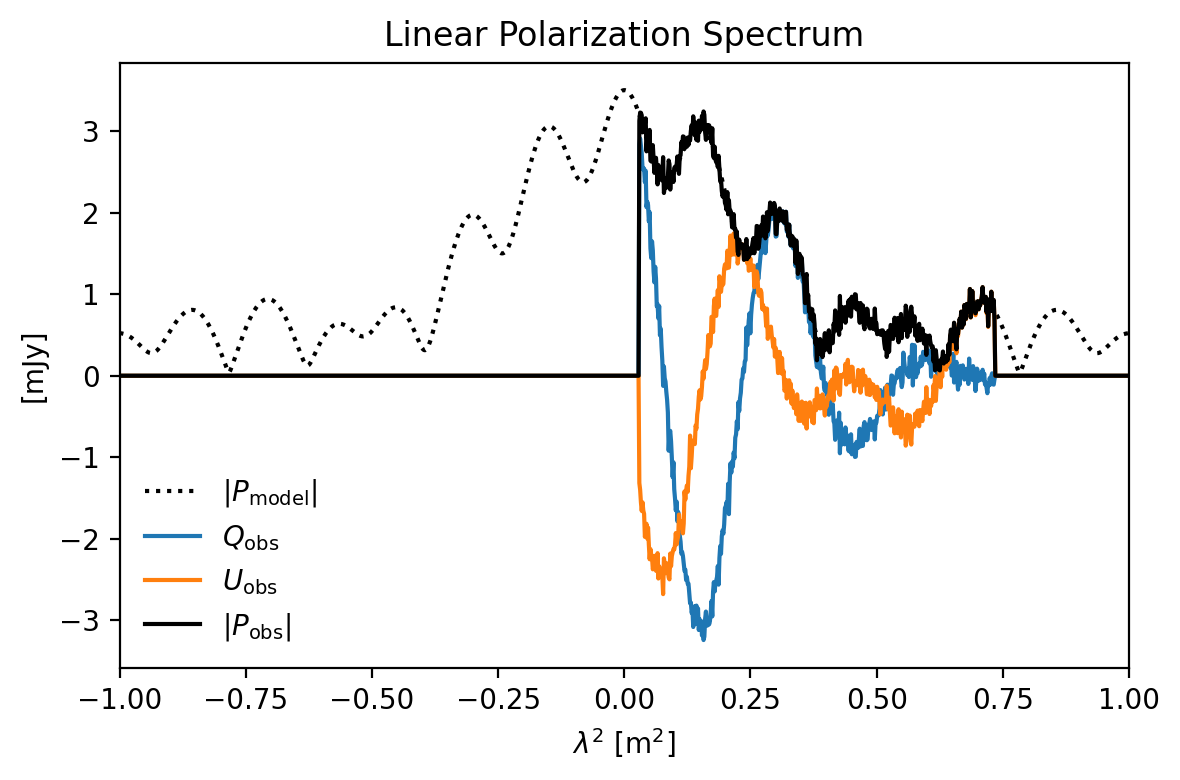

In [5]:
phi = np.array(FDF_model['Faraday depth'])
F_phi_model = np.array(FDF_model['Complex FDF'])

ls, P_lambda_squared_model = craft.IFT_1D(phi, F_phi_model)
# Adding Noise
noisy_P_lambda_squared_model = (np.random.normal(loc = np.real(P_lambda_squared_model), scale=noise_scale) 
           + 1j*np.random.normal(loc = np.imag(P_lambda_squared_model), scale=noise_scale))

# Limiting the observation coverage
P_lambda_squared_observed = noisy_P_lambda_squared_model.copy()
P_lambda_squared_observed[ls<ls_min] = 0
P_lambda_squared_observed[ls>ls_max] = 0

# Defining the mask and the window
ls_mask = np.ones(P_lambda_squared_observed.size)
ls_mask[P_lambda_squared_observed!=0] = 0
ls_wind = np.ones(P_lambda_squared_observed.size) - ls_mask

# Plot observation in lambda squared
plt.plot(ls, np.abs(P_lambda_squared_model), 'k', linestyle='dotted', label="|$P_{\mathrm{model}}$|")

plt.plot(ls, np.real(P_lambda_squared_observed), linestyle='solid', label="$Q_{\mathrm{obs}}$")
plt.plot(ls, np.imag(P_lambda_squared_observed), linestyle='solid', label="$U_{\mathrm{obs}}$")
plt.plot(ls, np.abs(P_lambda_squared_observed), 'k', linestyle='solid', label="|$P_{\mathrm{obs}}$|")

plt.xlim(-1.,1.)
plt.title("Linear Polarization Spectrum")
plt.ylabel(r"[mJy]")
plt.xlabel(r"$\lambda^2$ [m$^2$]")
plt.legend(frameon=False, loc='lower left')
plt.tight_layout()

print(r"Number of observation channels in lambda^2 are", (len(ls[ls_wind!=0])))

We can plot the RM synthesis result for comparison

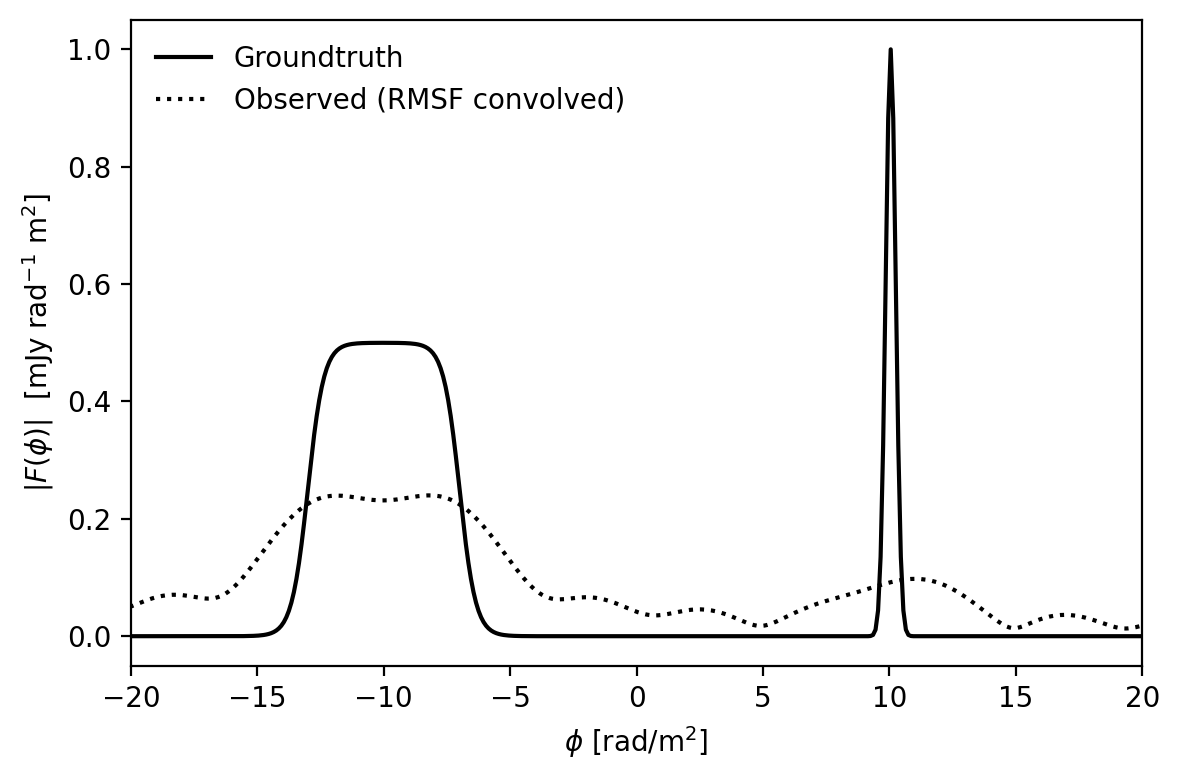

In [6]:
F_phi_observed = craft.FT_1D(ls, P_lambda_squared_observed)[1]

plt.plot(phi, np.abs(F_phi_model), 'k', linestyle="solid", label="Groundtruth")
plt.plot(phi, np.abs(F_phi_observed), 'k', linestyle="dotted", label = "Observed (RMSF convolved)")

plt.xlim(-20,20)
plt.xlabel(r"$\phi$ [rad/m$^{2}$]")
plt.ylabel(r"|$F(\phi)$|  [mJy rad$^{-1}$ m$^2$]")
plt.legend(frameon=False)
plt.tight_layout()

### Reconstruction of the FDF with CRAFT

In [7]:
phi_recon, F_phi_recon = craft.reconstruct_F(ls, P_lambda_squared_observed, 
                                                   ls_obs_min=ls_min, ls_obs_max=ls_max, 
                                                   mu=0.001, phi_max=500, rtol = 0.001, 
                                                   max_iter=1000)

ls_recon, P_ls_recon = craft.IFT_1D(phi_recon, F_phi_recon)

Number of iterations till convergence was 121


Let us now plot our FDF results. We show RM synthesis result for comparison.

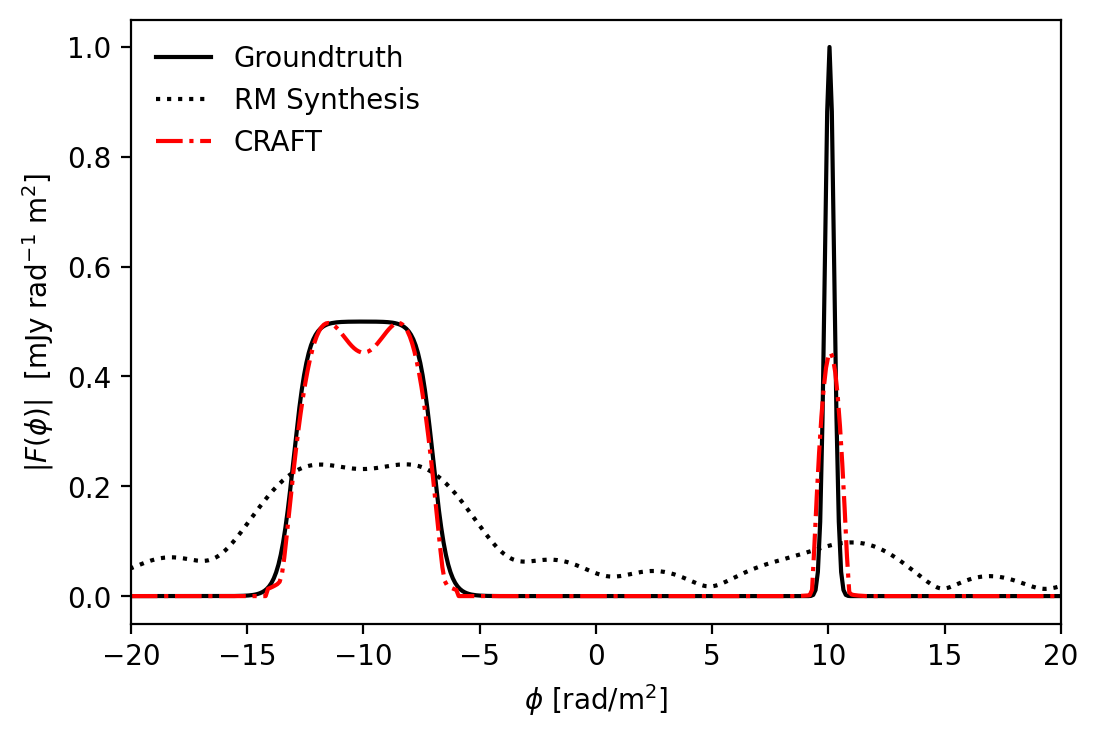

In [8]:
plt.plot(phi, np.abs(F_phi_model), 'k', linestyle="solid", label="Groundtruth")
plt.plot(phi, np.abs(F_phi_observed), 'k', linestyle="dotted", label = "RM Synthesis")
plt.plot(phi_recon, np.abs(F_phi_recon), 'r', linestyle="dashdot", label="CRAFT")

plt.xlim(-20,20)
plt.xlabel(r"$\phi$ [rad/m$^{2}$]")
plt.ylabel(r"|$F(\phi)$|  [mJy rad$^{-1}$ m$^2$]")
plt.legend(frameon=False, loc='upper left')

The polarization angle is also very reproduced. and much better than RM synthesis.

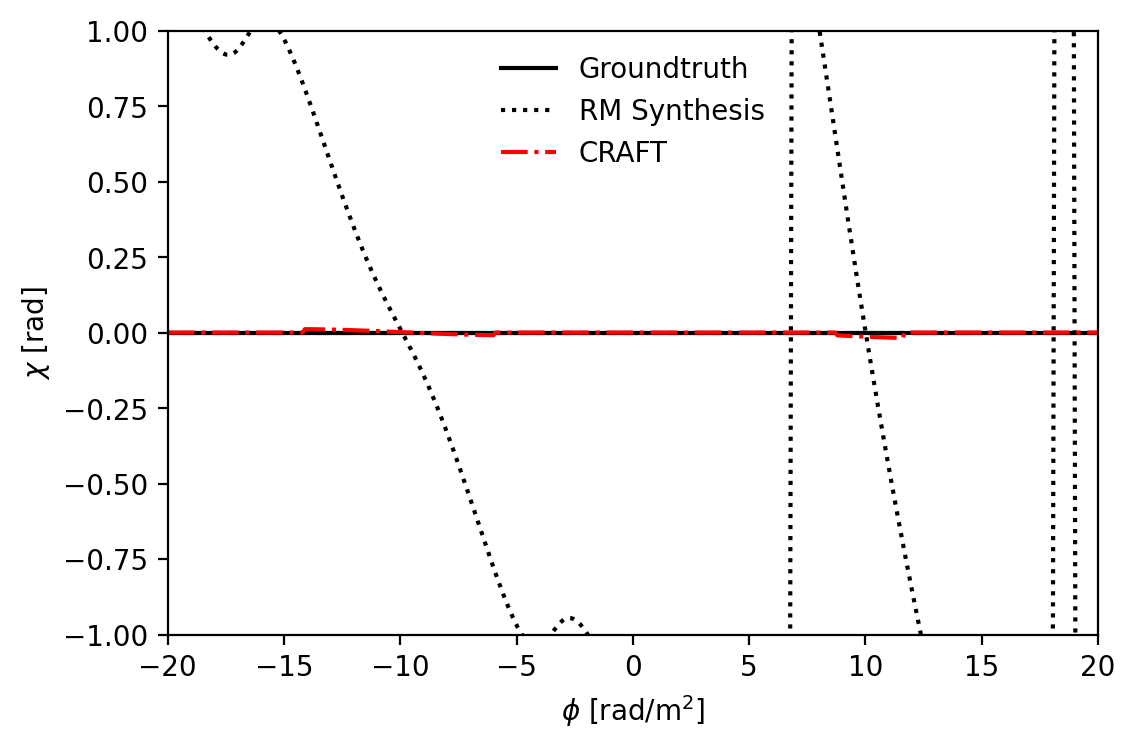

In [9]:
chi_model = np.angle(F_phi_model)/2
chi_obs = np.angle(F_phi_observed)/2
chi_recon = np.angle(F_phi_recon)/2

plt.plot(phi, chi_model,
         'k', linestyle='solid', label="Groundtruth")
plt.plot(phi, chi_obs,
         'k', linestyle="dotted", label = "RM Synthesis")
plt.plot(phi_recon, chi_recon,
         'r', linestyle='dashdot', label="CRAFT")

plt.hlines(0, xmin=-500, xmax=500, linestyles='dashed')

plt.xlim(-20,20)
plt.ylim(-1,1)
plt.xlabel(r"$\phi$ [rad/m$^{2}$]")
plt.ylabel(r"$\chi$ [rad]")
plt.legend(frameon=False)

And finally, wecan plot the reconstructed linear polarization spectrum. The negative $\lambda^2$ side is also very well reconstructed!

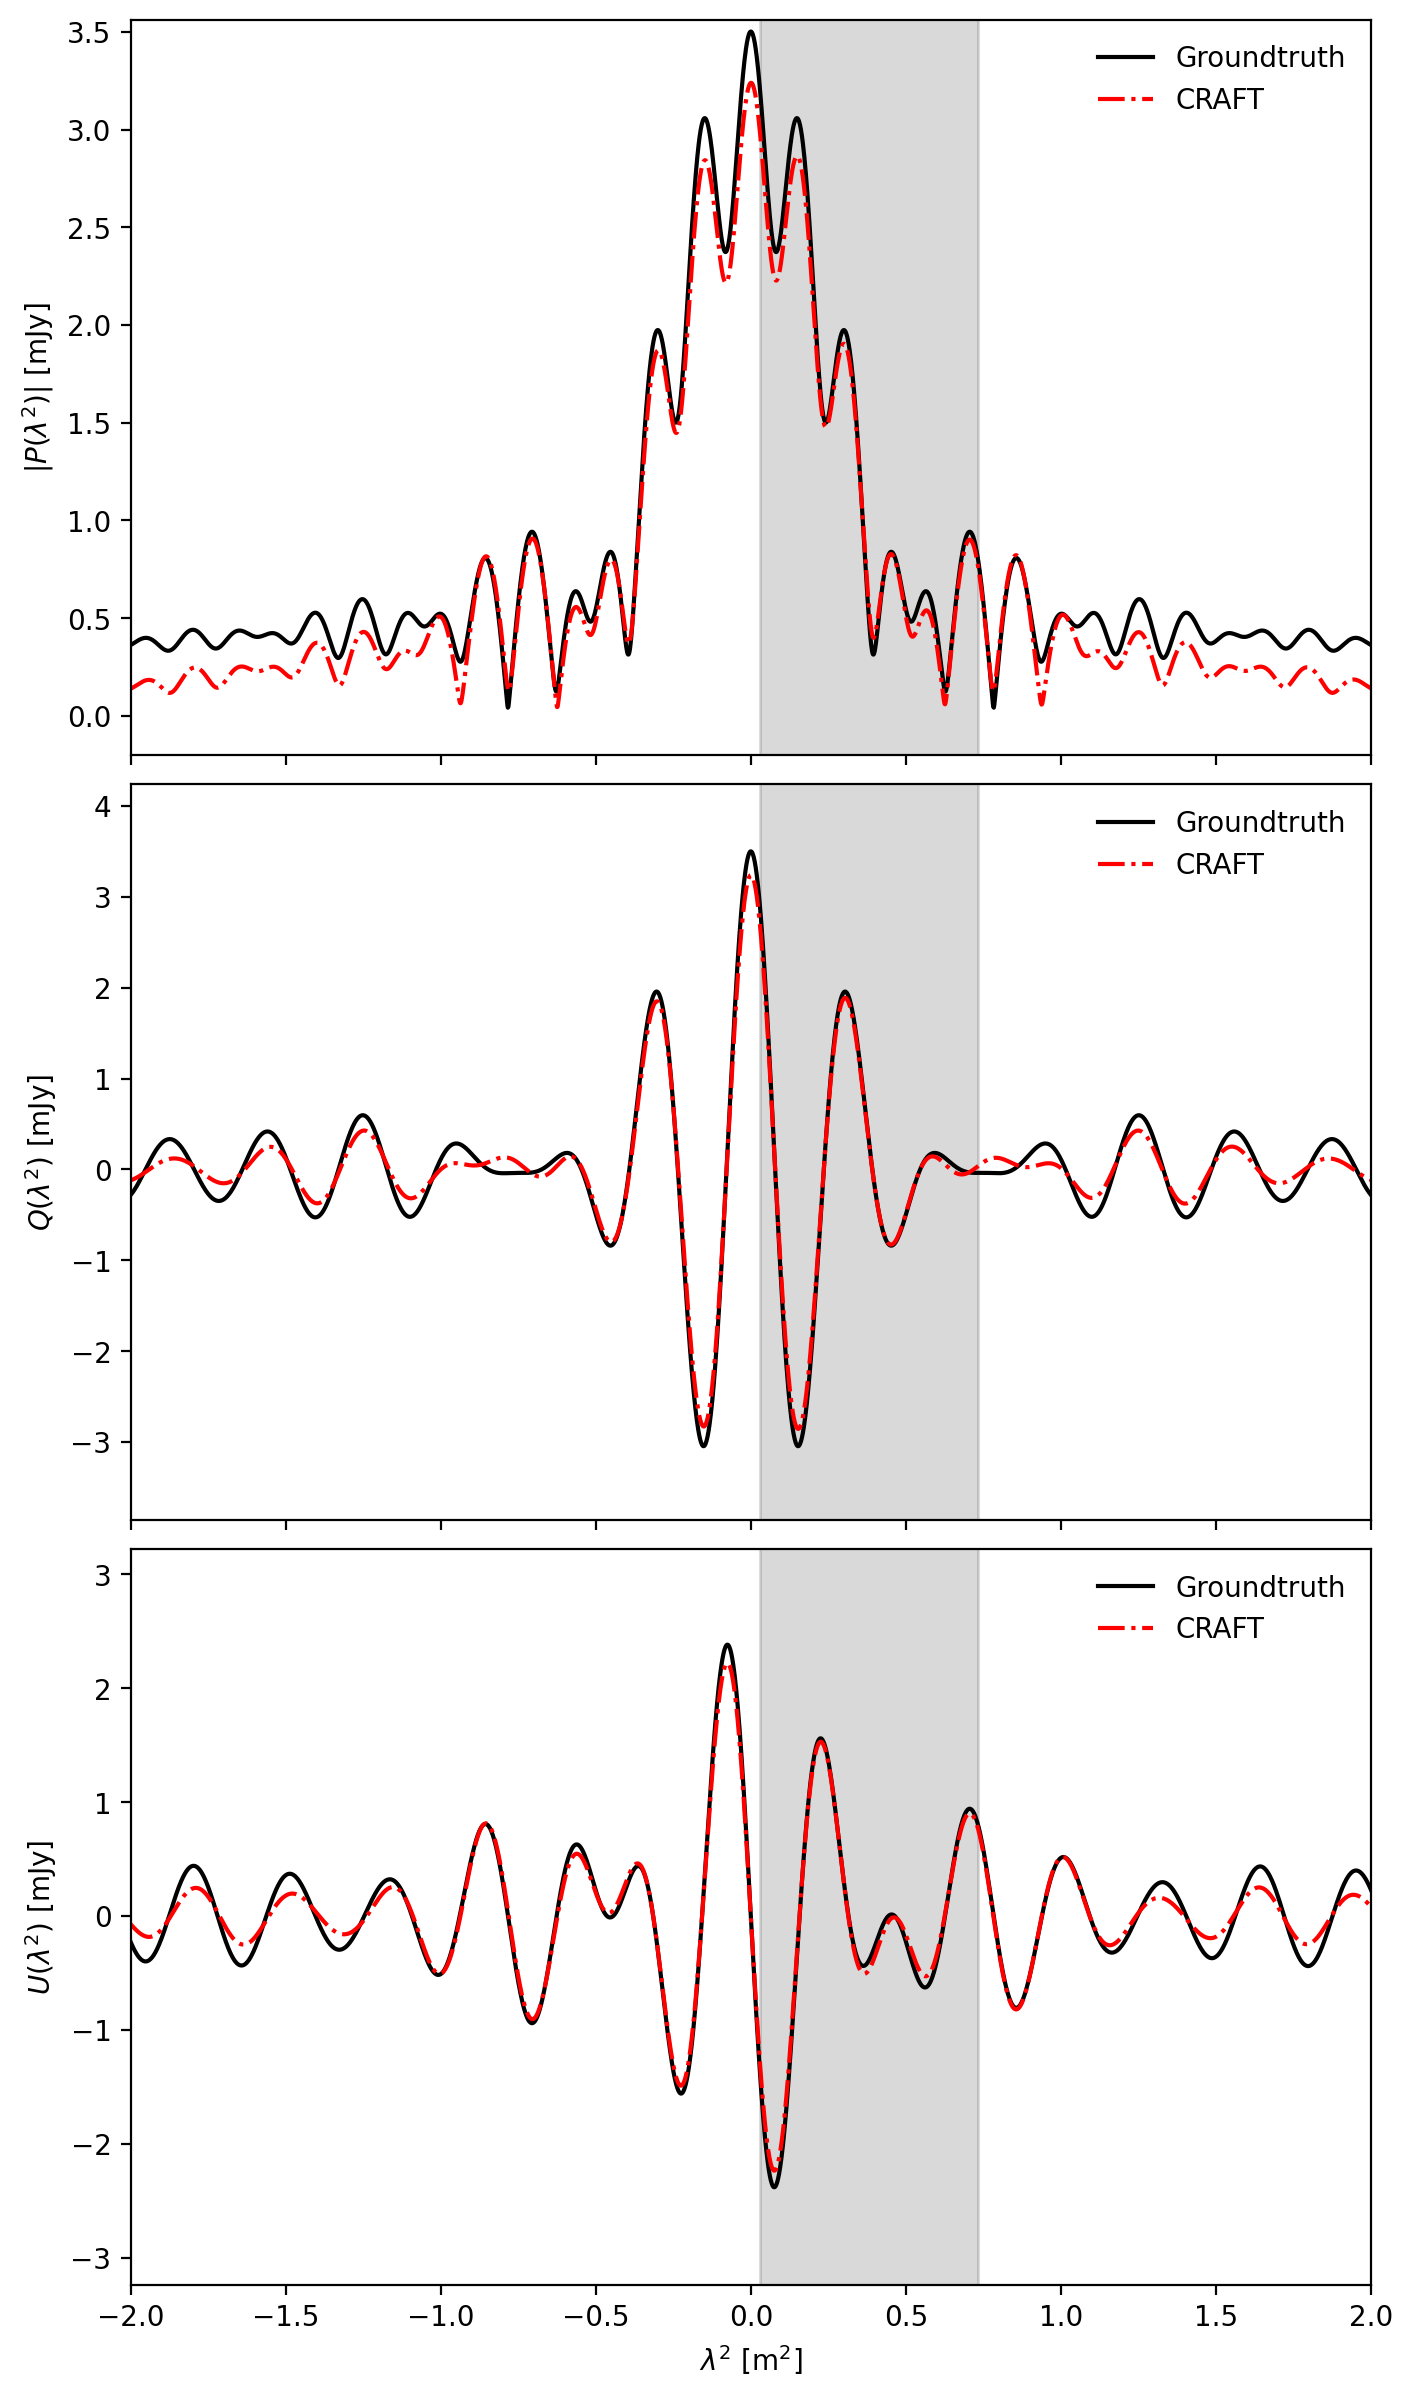

In [10]:
# Plot observation in lambda squared
ls_mask_plot = ls_wind > 0

fig, axs = plt.subplots(3, 1, sharex=True, sharey=False, figsize=(8, 15), 
                                gridspec_kw={'wspace':0.0, 'hspace':0.04})


axs[1].plot(ls, np.real(P_lambda_squared_model), 'k', linestyle='solid', label="Groundtruth")
axs[1].plot(ls_recon, np.real(P_ls_recon), 'r', linestyle='dashdot', label="CRAFT")

axs[2].plot(ls, np.imag(P_lambda_squared_model), 'k', linestyle='solid', label="Groundtruth")
axs[2].plot(ls_recon, np.imag(P_ls_recon), 'r', linestyle='dashdot', label="CRAFT")

axs[0].plot(ls, np.abs(P_lambda_squared_model), 'k', linestyle='solid', label="Groundtruth")
axs[0].plot(ls_recon, np.abs(P_ls_recon), 'r', linestyle='dashdot', label="CRAFT")

axs[1].fill_between(ls, -10, 10, 
                    where=(np.logical_and(ls>ls_min,ls<ls_max)), 
                    color='k', alpha=0.15)
axs[2].fill_between(ls, -10, 10, 
                    where=(np.logical_and(ls>ls_min,ls<ls_max)), 
                    color='k', alpha=0.15)
axs[0].fill_between(ls, -10, 10, 
                    where=(np.logical_and(ls>ls_min,ls<ls_max)), 
                    color='k', alpha=0.15)

axs[1].set_xlim(-2., 2.)
axs[2].set_xlim(-2., 2.)
axs[0].set_xlim(-2., 2.)

Q_ylim = 1.1*max(np.real(P_ls_recon))
if Q_ylim < -1.1*min(np.real(P_ls_recon)): 
    Q_ylim = -1.1*min(np.real(P_ls_recon))
    
U_ylim = 1.1*max(np.imag(P_ls_recon))
if U_ylim < -1.1*min(np.imag(P_ls_recon)): 
    U_ylim = -1.1*min(np.imag(P_ls_recon))
    
axs[1].set_ylim(min(np.real(P_ls_recon))-1, 
                max(np.real(P_ls_recon))+1)
axs[2].set_ylim(min(np.imag(P_ls_recon))-1, 
                max(np.imag(P_ls_recon))+1)

axs[0].set_ylim(-0.2, 1.1*max(np.abs(P_ls_recon)))

axs[1].set_ylabel(r"$Q$($\lambda^2$) [mJy]")
axs[2].set_ylabel(r"$U$($\lambda^2$) [mJy]")
axs[0].set_ylabel(r"|$P$($\lambda^2$)| [mJy]")

axs[2].set_xlabel(r"$\lambda^2$ [m$^2$]")
axs[0].legend(frameon=False)
axs[1].legend(frameon=False)
axs[2].legend(frameon=False)